In [2]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
import time
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from nltk import PorterStemmer
ps = PorterStemmer()
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.constraints import unit_norm
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, add, Input, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

print(tf.__version__)
%matplotlib inline

2.0.0


Using TensorFlow backend.


## Read in Data 

Here we read in the data as well as take a subset of the entire dataset to actually work on. The entire dataset is 1.5 million tweets, so we only use 60,000 of them due to computational limits.

In [5]:
# Define number of columns to be read in
n = 4
# Get training dataset - Sentiment Analysis csv that we found
data = pd.read_csv('Sentiment Analysis Dataset.csv', usecols=range(n), lineterminator='\n', header = 0)
# Copy it so we always have an original
originalFullset = data.copy()

# Remove sentimentSource column - does not add any useful information
data.drop("SentimentSource", axis = 1, inplace = True)

# Rename SentimentText\r to Tweet to make it easier to work with
data = data.rename(columns = {"SentimentText\r": "Tweet"})

data = data[:60000]

data

# For this dataset 0 is negative, 1 is positive

,ItemID,Sentiment,Tweet
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O\r
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
...,...,...,...
59995,60007,0,"@BgirlShorty jealous, its bedtime for me \r"
59996,60008,1,@BgirlShorty looking pimp in those jerseys!! h...
59997,60009,1,@BgirlShorty lucky !!!!!!! hahah you all have...
59998,60010,0,@belledame222 I don't understand why socialist...


## Understand Distribution of Data

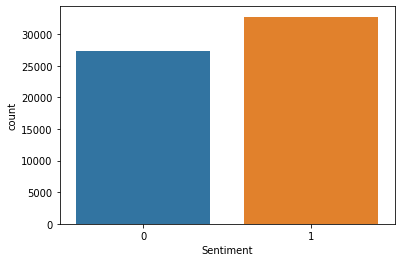

In [6]:
# View distribution of data before preprocessing
sns.countplot(data = data, x = "Sentiment")

Clearly, our data takes a fairly even split between positive and negatively labeled tweets. Thus, we choose accuracy as our metric of choice when analyzing our models.

## Preprocessing

In [7]:
# Function that will remove patterns and phrases that do not add anything to the tweet
# such as handles and punctuation

def deletePart(text, part):
    # Get all instances of part in the text
    r = re.findall(part,text)
    
    # Sub out these unnecessary patterns for a blank space
    for i in r:
        text = re.sub(i,"",text)
        
        
    return text


In [8]:
# Define new column of dataframe as processed tweet
data['CleanTweet'] = np.vectorize(deletePart)(data['Tweet'], "@[\w]*")

# Replace all special characters with a space
data['CleanTweet'] = data['CleanTweet'].str.replace("[^a-zA-Z#]", " ")

# Replace all hashtags with empty space
data['CleanTweet'] = data['CleanTweet'].str.replace("#", "")

# Delete all words with 3 or less letters
data['CleanTweet'] = data['CleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Make all words lowercase
data['CleanTweet'] = data['CleanTweet'].apply(lambda x: x.lower())


# Display the head
data.head(100)

,ItemID,Sentiment,Tweet,CleanTweet
0,1,0,is so sad for my APL frie...,friend
1,2,0,I missed the New Moon trail...,missed moon trailer
2,3,1,omg its already 7:30 :O\r,already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga sooo gunna been this dentist since supo...
4,5,0,i think mi bf is cheating on me!!! ...,think cheating
...,...,...,...,...
95,96,0,mi momacita won't let me go to my bf's bball...,momacita bball game grrr
96,97,0,Mom says I have to get a new phone IMMEDIATE...,says have phone immediately mobile paying
97,98,0,My new car was stolen....by my mother who wa...,stolen mother wanted pose church
98,99,0,"no hang out with the girls 2day. 2moro, hope...",hang with girls moro hope


In [9]:
#Tokenize tweet into just words
tokenizedData = data['CleanTweet'].apply(lambda x: x.split())

tokenizedData.head()

0                                             [friend]
1                              [missed, moon, trailer]
2                                            [already]
3    [omgaga, sooo, gunna, been, this, dentist, sin...
4                                    [think, cheating]
Name: CleanTweet, dtype: object

In [10]:
# Define method to lemmatize words in a tweet
def lemmatization(word_vector):
    
    lem = WordNetLemmatizer()
    lemmatized_tweet = []
    
    # Lemmatize data
    for word in word_vector:
        lemmatized_text = lem.lemmatize(word, 'v')
        lemmatized_tweet.append(lemmatized_text)
    
    return lemmatized_tweet

In [11]:
# Apply lemmatization to tokenized data
tokenizedData = tokenizedData.apply(lambda x: lemmatization(x))

tokenizedData.head()

0                                             [friend]
1                                [miss, moon, trailer]
2                                            [already]
3    [omgaga, sooo, gunna, be, this, dentist, since...
4                                       [think, cheat]
Name: CleanTweet, dtype: object

In [12]:
# Stitch it all back together into a tweet
for i in range(len(tokenizedData)):
    tokenizedData[i] = ' '.join(tokenizedData[i])

data['CleanTweet'] = tokenizedData

# Replace all instances of "quot" and "http"
data['CleanTweet'] = data['CleanTweet'].str.replace("quot", "")
data['CleanTweet'] = data['CleanTweet'].str.replace("http", "")

data.head()

,ItemID,Sentiment,Tweet,CleanTweet
0,1,0,is so sad for my APL frie...,friend
1,2,0,I missed the New Moon trail...,miss moon trailer
2,3,1,omg its already 7:30 :O\r,already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga sooo gunna be this dentist since supose...
4,5,0,i think mi bf is cheating on me!!! ...,think cheat


## Vectorize Data

We use sci-kit learn's CountVectorizer in order to transform our data into a bag-of-words matrix that can then be fed into the logistic regression and subsequent models. The Tokenizer performs the same action for our keras neural network.

In [13]:
# Vectorize the word counts for all of the tweets
vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# Create tokinizer for the neural network
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['CleanTweet'])
# Fit and transform the tweet for the tokinizer
tokenizedData = tokenizer.texts_to_sequences(data['CleanTweet'])
#print an example for the tokinized data
print(tokenizedData[150])


# Bag-of-words feature matrix
bow = vectorizer.fit_transform(data['CleanTweet'])
# Transform into data frame
df_bow = pd.DataFrame(bow.todense())
# Standardize the data
standardized_X = preprocessing.scale(df_bow)

#set y to the labels column
y = data['Sentiment']

[4910, 466, 757]


In [12]:
# Perform TFIDF vectorization on data
tfidfconverter = TfidfVectorizer(max_features = 2000, min_df = 2, max_df = 0.9, stop_words = stopwords.words('english'))
# Fit TF-IDF Vectorizer to dataset
bow_tfidf = tfidfconverter.fit_transform(data['CleanTweet'])

df_bow_tfidf = pd.DataFrame(bow_tfidf.todense())

standardized_X_tfidf = preprocessing.scale(df_bow_tfidf)

y = data['Sentiment']

## Model Evaluation

### Logistic Regression using TF-IDF Vectorization

In [31]:
start = time.time()
# Train model using logistic regression and CV with 10 folds
y_pred = cross_val_predict(LogisticRegression(), standardized_X_tfidf, y, cv = 10)
stop = time.time()
print("Logistic Regression with TF-IDF instead of CountVectorizer")
print(metrics.classification_report(y, y_pred))
print(metrics.confusion_matrix(y, y_pred))

print(f"Training time: {stop - start}s")

Logistic Regression with TF-IDF instead of CountVectorizer
              precision    recall  f1-score   support

           0       0.70      0.63      0.66     27257
           1       0.72      0.78      0.75     32743

    accuracy                           0.71     60000
   macro avg       0.71      0.70      0.71     60000
weighted avg       0.71      0.71      0.71     60000

[[17203 10054]
 [ 7306 25437]]
Training time: 362.4056282043457s


### Logistic Regression and Decision Tree using CountVectorizer

In [506]:
start = time.time()
# Train our model using cross validation with 10 folds, and logistic regression
y_pred = cross_val_predict(LogisticRegression(),standardized_X, data['Sentiment'], cv=10)
stop = time.time()
print("Using Logistic Regression")
print(metrics.classification_report(y, y_pred))
print(metrics.confusion_matrix(y, y_pred))
print(f"Training time: {stop - start}s")

start = time.time()
# Train our model using cross validation with 10 folds, and decision trees
tree = DecisionTreeClassifier(random_state=52)
y_pred = cross_val_predict(tree,standardized_X, y, cv=10)
stop = time.time()
print("Using Decision Trees")
print(metrics.classification_report(y, y_pred))
print(metrics.confusion_matrix(y, y_pred))
print(f"Training time: {stop - start}s")

Using Logistic Regression
              precision    recall  f1-score   support

           0       0.72      0.59      0.65     27257
           1       0.70      0.81      0.75     32743

    accuracy                           0.71     60000
   macro avg       0.71      0.70      0.70     60000
weighted avg       0.71      0.71      0.71     60000

[[16194 11063]
 [ 6354 26389]]
Training time: 15.473104000091553s
Using Decision Trees
              precision    recall  f1-score   support

           0       0.62      0.61      0.62     27257
           1       0.68      0.68      0.68     32743

    accuracy                           0.65     60000
   macro avg       0.65      0.65      0.65     60000
weighted avg       0.65      0.65      0.65     60000

[[16738 10519]
 [10432 22311]]
Training time: 1314.553482055664s


### AdaBoost Classifier

In [508]:
start = time.time()
# Use Adaboost classifier
adaBoost = AdaBoostClassifier(n_estimators = 100)

# Evaluate model using 10 fold CV
y_pred = cross_val_predict(adaBoost,standardized_X, y, cv=10)
stop = time.time()
print("Using AdaBoost")
print(metrics.classification_report(y, y_pred))
print(metrics.confusion_matrix(y, y_pred))
print(f"Training time: {stop - start}s")

Using AdaBoost
              precision    recall  f1-score   support

           0       0.74      0.48      0.58     27257
           1       0.66      0.86      0.75     32743

    accuracy                           0.69     60000
   macro avg       0.70      0.67      0.66     60000
weighted avg       0.70      0.69      0.67     60000

[[12961 14296]
 [ 4555 28188]]
Training time: 1371.8239090442657s


### Multi-layer Perceptron

In [14]:
# Split the data first into train and test
x_train, x_test, y_train, y_test = train_test_split(tokenizedData, y, test_size=0.3)

In [15]:
vocab_size = len(tokenizer.word_index) + 1 #need these variables for the model
embedding_dim = 50

# Make sure all parts are inputted as arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

from keras.preprocessing.sequence import pad_sequences

maxlen = 100
# Introduce padding so that all of the arrays are the same length (will just put 0 in spots for where there's no words)
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [16]:
from keras.regularizers import l2

# Define and compile the model
NNmodel = Sequential()

NNmodel.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
NNmodel.add(layers.GlobalMaxPool1D())
NNmodel.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.05), bias_regularizer=l2(0.05)))
NNmodel.add(Dropout(.5))           
NNmodel.add(layers.Dense(1, activation='sigmoid'))
NNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [17]:
start = time.time()
#save the fit as 'history' for accessing the values later
history = NNmodel.fit(x_train, y_train, epochs=5, batch_size =64, validation_data = (x_test, y_test))
stop = time.time()
print(f"Training time: {stop - start}s")

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 36s 864us/sample - loss: 0.7867 - accuracy: 0.6057 - val_loss: 0.6321 - val_accuracy: 0.6882
Epoch 2/5
42000/42000 [==============================] - 35s 842us/sample - loss: 0.6039 - accuracy: 0.7042 - val_loss: 0.5710 - val_accuracy: 0.7271
Epoch 3/5
42000/42000 [==============================] - 37s 884us/sample - loss: 0.5558 - accuracy: 0.7410 - val_loss: 0.5557 - val_accuracy: 0.7322
Epoch 4/5
42000/42000 [==============================] - 38s 912us/sample - loss: 0.5280 - accuracy: 0.7587 - val_loss: 0.5511 - val_accuracy: 0.7334
Epoch 5/5
42000/42000 [==============================] - 37s 881us/sample - loss: 0.5096 - accuracy: 0.7770 - val_loss: 0.5521 - val_accuracy: 0.7323
Training time: 184.29200291633606s


### Visualization of the Data

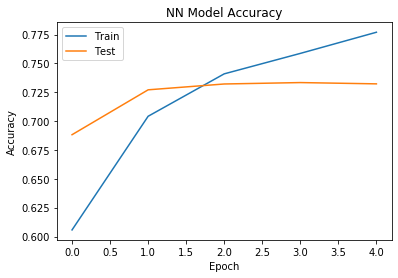

In [18]:
#plot the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('NN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

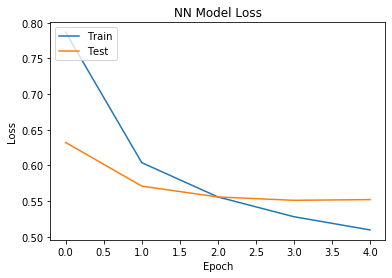

In [19]:
# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('NN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [61]:
# Pick out only the positive labeled tweets
pos = (data['CleanTweet'][data['Sentiment'] == 1])
# Split the words
pos = pos.apply(lambda x: x.split())
# Combine all like words
pos = sum(pos, [])

# Do the same for negative
neg = (data['CleanTweet'][data['Sentiment'] == 0])
neg = neg.apply(lambda x: x.split())
neg = sum(neg, [])

In [66]:
# Find the frequency counts of the positive key words
posFrequency = nltk.FreqDist(pos)
# Find the frequency counts of the negative key words
negFrequency = nltk.FreqDist(neg)

#turn the counts into seperate dataframes
dfPos = pd.DataFrame({'Key Word':list(posFrequency.keys()), 'Count':list(posFrequency.values())})
dfNeg = pd.DataFrame({'Key Word':list(negFrequency.keys()), 'Count':list(negFrequency.values())})


     Counts of the Top 15 Words Associated with Positive Tweets


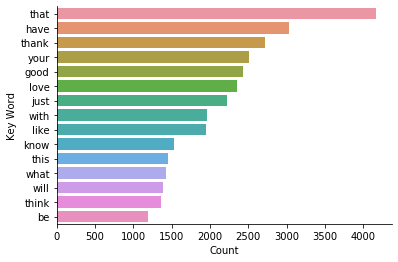

In [67]:
# Plot the data
posPlot = dfPos.nlargest(15, columns = 'Count')
print("     Counts of the Top 15 Words Associated with Positive Tweets")
sns.barplot(data=posPlot,y='Key Word',x='Count')
sns.despine()

     Counts of the Top 15 Words Associated with Negative Tweets


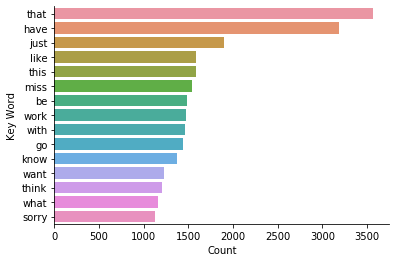

In [68]:
negPlot = dfNeg.nlargest(15, columns = 'Count')
print("     Counts of the Top 15 Words Associated with Negative Tweets")
sns.barplot(data=negPlot,y='Key Word',x='Count')
sns.despine()

In [19]:
# twitter API setup
import requests
import tweepy
import dataset
from datafreeze import freeze

# Initialize keys and tokens
TWITTER_APP_KEY = '25cd5UcxhXgU0wNmwtebw93qV'
TWITTER_APP_SECRET = 'F9e6DW9gDOC1NXqAGNez7lfFKNvd8EiiF90PHFUzSemmAke0fE'
ACCESS_TOKEN = '1258414173823864835-bEZqrXBHXablc3OmUOL895ftQ4eUea'
ACCESS_TOKEN_SECRET = 'SiBAA2YMOxNZOG38lHR4QBvzsVQQpOI0WWv43jWn8XbpP'

TRACK_TERMS = ["covid19", "coronavirus", "virus", "covid"]
CONNECTION_STRING = "sqlite:///tweets.db"
CSV_NAME = "tweets.csv"
TABLE_NAME = "tweets"

tweets = []

# Initialize authorization
auth = tweepy.OAuthHandler(TWITTER_APP_KEY, TWITTER_APP_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)

# Redefine methods in streamlistener class
class StreamListener(tweepy.StreamListener):
    
    # Override on_status method to simply print out the text of a tweet
    def on_status(self, status):
        print(status.text)
        
        # Get text of tweet
        tweet = status.text

        # Connect to sqlite db to store tweets
        db = dataset.connect(CONNECTION_STRING)

        table = db[TABLE_NAME]
        table.insert(dict(
            text = tweet))
                
    # Override on error to prevent to disconnect at a rate limit
    def on_error(self, status_code):
        if status_code == 420:
            return False

In [23]:
# Scraper functionality
stream_listener = StreamListener()
stream = tweepy.Stream(auth = api.auth, listener = stream_listener)
stream.filter(track = TRACK_TERMS)

# Ctrl-c to kill it

In [21]:
# Transform database into a csv and export
db = dataset.connect("sqlite:///tweets.db")
result = db[TABLE_NAME].all()

# Store results in csv
freeze(result, format='csv', filename=CSV_NAME)

In [3]:
# Read in tweets csv
api_data = pd.read_csv('tweets.csv', header = 0)

# Delete id column
del api_data['id']

api_data

,text
0,Question: Do you think Trump has shed a single...
1,RT @libraryluna: Public libraries are perfect ...
2,RT @ubasociales: CONFERENCIA VIRTUAL DE GARCÍA...
3,@TODAYshow How dare you make me wear a device ...
4,RT @funder: Whatever you do don’t retweet this...
...,...
345,RT @mazeemkhan74: While more evidences emerge ...
346,RT @bajabiri: Friend of @Kiganyi_ Anataka acce...
347,RT @Gaby51904891: Han muerto 40000 españoles. ...
348,RT @MaricelaSerHdz: Mi reconocimiento a su gra...


In [20]:
# Create new tokenizer for the neural network
tokenizer_api = Tokenizer(num_words=1000)
tokenizer_api.fit_on_texts(api_data['text'])

# Fit and transform the tweet for the tokinizer
tokenizedDataApi = tokenizer_api.texts_to_sequences(api_data['text'])

# Print an example for the tokinized data
print(tokenizedDataApi[50])

vocab_size = len(tokenizer_api.word_index) + 1 #need these variables for the model
embedding_dim = 50

# Make sure all parts are inputted as arrays
tokenizedDataApi = np.array(tokenizedDataApi)

from keras.preprocessing.sequence import pad_sequences

maxlen = 100
# Introduce padding so that all of the arrays are the same length (will just put 0 in spots for where there's no words)
tokenizedDataApi = pad_sequences(tokenizedDataApi, padding='post', maxlen=maxlen)

[1, 123, 101, 41, 21, 19, 12, 8, 124, 144, 78, 440, 8, 12, 427, 34]


In [22]:
# Make predictions on the new dataset
predictions = NNmodel.predict_classes(tokenizedDataApi)

# Save predictions for each tweet in dataframe
api_data['Predicted Sentiment'] = predictions

# Show a few samples
for i in range(10):
    print("'", api_data['text'][i],"'", " \nPredicted Sentiment:", api_data['Predicted Sentiment'][i])

' Question: Do you think Trump has shed a single tear for any of the victims of covid 19? '  
Predicted Sentiment: 1
' RT @libraryluna: Public libraries are perfect places for COVID-19 to spread, and states should back that up by encouraging alternative/no-c… '  
Predicted Sentiment: 0
' RT @ubasociales: CONFERENCIA VIRTUAL DE GARCÍA LINERA EN #FSOC #UBA

Miles de personas siguieron en vivo la conferencia virtual del Profeso… '  
Predicted Sentiment: 1
' @TODAYshow How dare you make me wear a device to protect me and others from a deadly virus. Let me get my seat belt… https://t.co/vUDqVd3kYe '  
Predicted Sentiment: 0
' RT @funder: Whatever you do don’t retweet this video, it will make Trump furious. It shows every time Trump lied about and downplayed coron… '  
Predicted Sentiment: 1
' À cause du coronavirus, Takao Saito et le magazine Big Comic se sont mis d'accord afin d'assurer la sécurité sanita… https://t.co/reWDpJWeBG '  
Predicted Sentiment: 1
' RT @TheLastWord: Dr. Clifton Ha